For some reason, the below package, doesnt appear in this, so for the first time run, need to install it

In [1]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install pyod

In [2]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install plotly

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import percentile

import warnings
warnings.filterwarnings("ignore")

import matplotlib

from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq

import plotly.express as px

### Loading the data

In [4]:
df = pd.read_csv('ReportA_buyingretail.csv')

#df.head()

In [5]:
df['date'] = pd.to_datetime(df['date'])

df['datecreated'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 15 columns):
date                5106 non-null datetime64[ns]
old_mcm             5106 non-null object
new_mcm             5106 non-null object
new_outletid        5106 non-null object
accountid           5106 non-null object
old_outletid        5106 non-null int64
merchantname        5106 non-null object
datecreated         5106 non-null datetime64[ns]
merchantcategory    5106 non-null object
businesscategory    5106 non-null object
city                5106 non-null object
state               5106 non-null object
lwusercnt           5106 non-null int64
lwgtv               5106 non-null float64
gtv_user            5106 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(2), object(9)
memory usage: 598.5+ KB


In [6]:
df['merchantcategory'].unique()

array(['Individual Merchant'], dtype=object)

In [7]:
df.describe()

,old_outletid,lwusercnt,lwgtv,gtv_user
count,5106.000000,5106.000000,5106.000000,5106.000000
mean,96082.201136,2.501958,232.238829,84.067869
std,38320.597885,2.174398,582.306148,224.346205
min,3512.000000,1.000000,0.010000,0.010000
25%,70790.000000,1.000000,23.000000,12.192500
50%,104329.000000,2.000000,64.700000,26.945000
75%,127805.000000,3.000000,187.000000,65.000000
max,145955.000000,10.000000,9805.000000,4830.000000


In [8]:
df.shape

(5106, 15)

## Exploring the data

### gtv/user

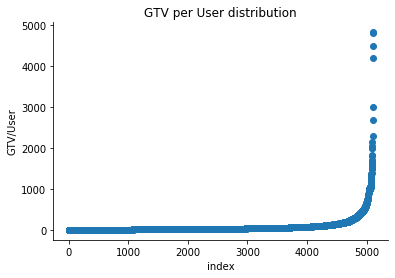

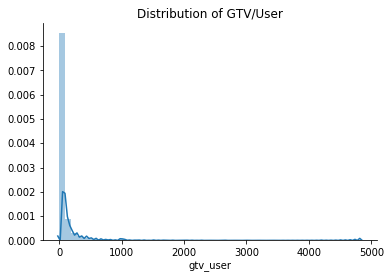

Skewness: 9.881472
Kurtosis: 152.799210


In [9]:
#exploring the gtv_user
plt.scatter(range(df.shape[0]), np.sort(df['gtv_user'].values))
plt.xlabel('index')
plt.ylabel('GTV/User')
plt.title("GTV per User distribution")
sns.despine()
plt.show()

sns.distplot(df['gtv_user'])
plt.title('Distribution of GTV/User')
sns.despine()
plt.show()

print("Skewness: %f" % df['gtv_user'].skew())
print("Kurtosis: %f" % df['gtv_user'].kurt())

**Notes**

Kurtosis looks at the tailedness of the probability

$$
Kurt[X] = E\bigg{[}\bigg{(}\frac{X-\mu}{\sigma}\bigg{)}^4\bigg{]} = \frac{E\big{[}(X-\mu)^4 \big{]}}{\big{(} E [ (X-\mu)^2]\big{)}^2} = \frac{\mu_4}{\sigma^4}
$$


Skewness is a measure of symmetry
$$
\tilde{\mu_3} = \frac{\sum_{i}^{N} (X_i - \bar{X})^3}{(N-1)*\sigma^3}
$$

### LWGTV


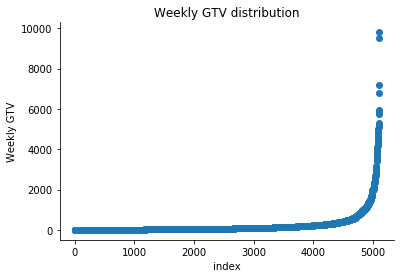

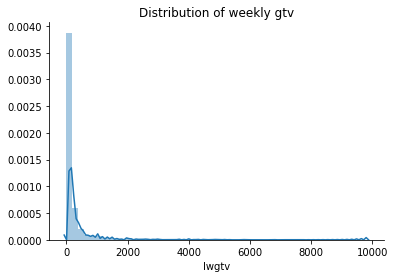

Skewness: 6.561408
Kurtosis: 60.496857


In [10]:
#exploring the lw_gtv
plt.scatter(range(df.shape[0]), np.sort(df['lwgtv'].values))
plt.xlabel('index')
plt.ylabel('Weekly GTV')
plt.title("Weekly GTV distribution")
sns.despine()
plt.show()

sns.distplot(df['lwgtv'])
plt.title('Distribution of weekly gtv')
sns.despine()
plt.show()

print("Skewness: %f" % df['lwgtv'].skew())
print("Kurtosis: %f" % df['lwgtv'].kurt())

### User count

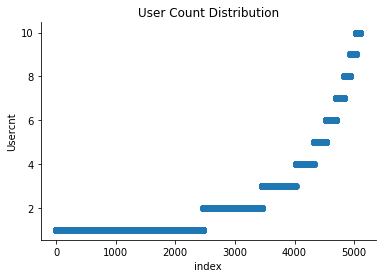

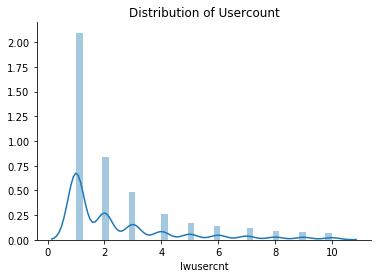

Skewness: 1.729921
Kurtosis: 2.339834


In [11]:
#exploring the usrcnt
plt.scatter(range(df.shape[0]), np.sort(df['lwusercnt'].values))
plt.xlabel('index')
plt.ylabel('Usercnt')
plt.title("User Count Distribution")
sns.despine()
plt.show()

sns.distplot(df['lwusercnt'])
plt.title('Distribution of Usercount')
sns.despine()
plt.show()

print("Skewness: %f" % df['lwusercnt'].skew())
print("Kurtosis: %f" % df['lwusercnt'].kurt())

## Using Isolation Forests

Reason behind this is because we want something explainable to be able to use
- isolation forests will allow us to get a specific number threshold
- maybe will be good for this analysis

/Users/fzdanial/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


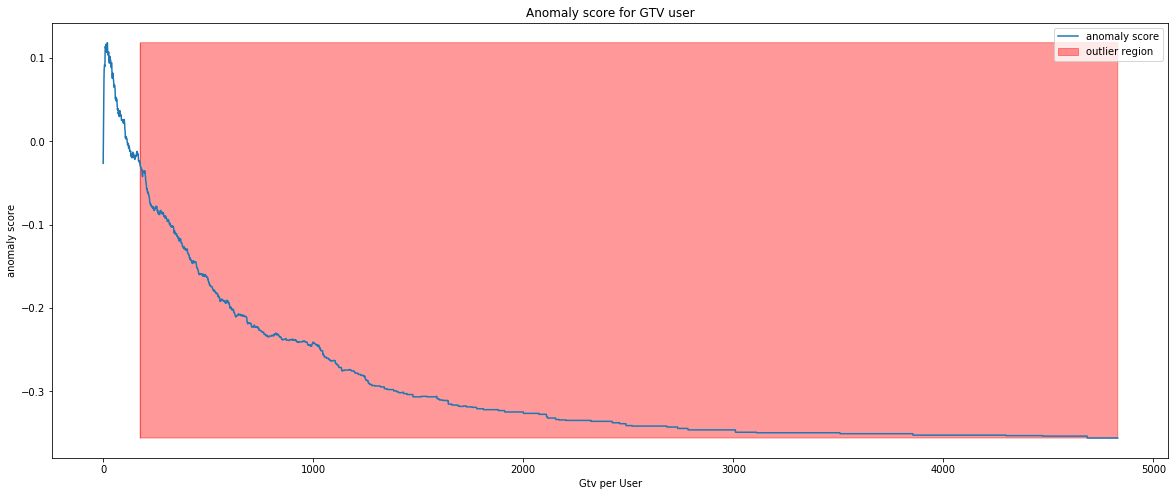

In [12]:
#gtv_user
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['gtv_user'].values.reshape(-1, 1))

xx = np.linspace(df['gtv_user'].min(), df['gtv_user'].max(), len(df)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)

outlier = isolation_forest.predict(xx)

plt.figure(figsize=(20,8))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Gtv per User')
plt.title('Anomaly score for GTV user')
plt.show()

/Users/fzdanial/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


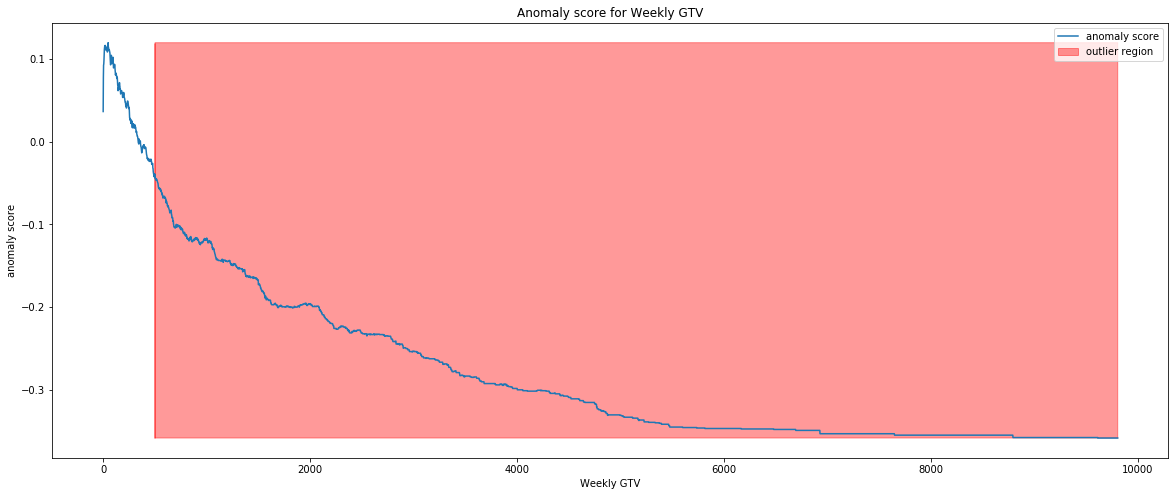

In [13]:
#lwgtv
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['lwgtv'].values.reshape(-1, 1))

xx = np.linspace(df['lwgtv'].min(), df['lwgtv'].max(), len(df)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)

outlier = isolation_forest.predict(xx)

plt.figure(figsize=(20,8))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Weekly GTV')
plt.title('Anomaly score for Weekly GTV')
plt.show()

/Users/fzdanial/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


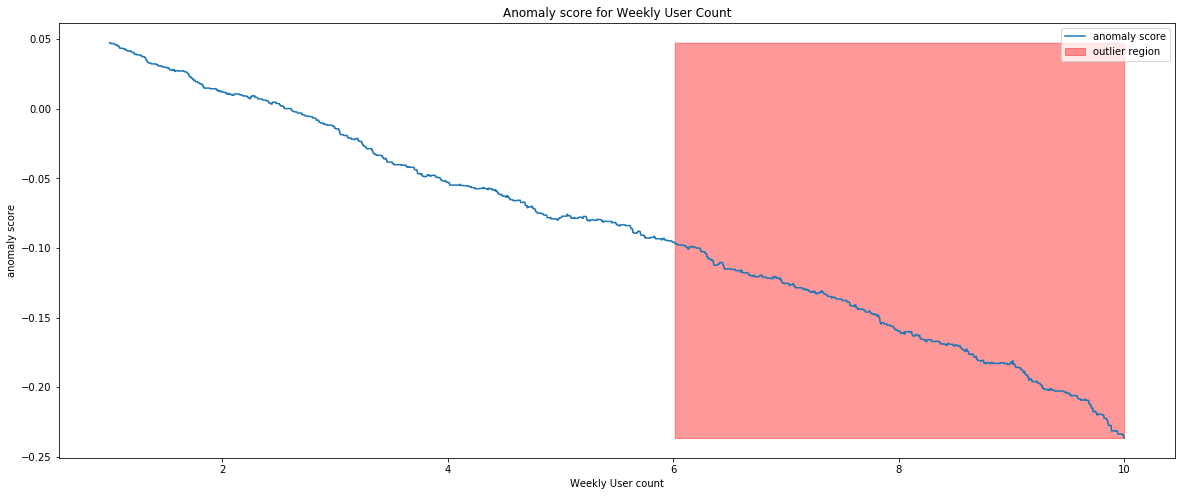

In [14]:
#user count
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['lwusercnt'].values.reshape(-1, 1))

xx = np.linspace(df['lwusercnt'].min(), df['lwusercnt'].max(), len(df)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)

outlier = isolation_forest.predict(xx)

plt.figure(figsize=(20,8))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Weekly User count')
plt.title('Anomaly score for Weekly User Count')
plt.show()

In [15]:
#df.loc[(df['gtv_user'] >= 2000.0)].sort_values(by = 'gtv_user')

the only thing odd here is the ones above 3 thousand, but no direct correlation yet

Ask LY/Anis to check out:
- MCM0037662 on the week of 2021-11-01
- MCM0079141 on the week of 2021-11-29
- MCM0091886 on the week of 2021-10-25
- MCM0065249 on the week of 2021-11-08

## Multivariate anomaly analysis

In [ ]:
sns.regplot(x="lwusercnt", y="lwgtv", data=df)
sns.despine()

In [ ]:
sns.regplot(x="gtv_user", y="lwgtv", data=df)
sns.despine()

In [ ]:
df['unix'] = (df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

sns.regplot(x="unix", y="lwgtv", data=df)
sns.despine()

### CBLOF

In [ ]:
cols = ['lwusercnt', 'lwgtv']
df[cols].head()

In [ ]:
minmax = MinMaxScaler(feature_range=(0, 1))
df[['lwusercnt','lwgtv']] = minmax.fit_transform(df[['lwusercnt','lwgtv']])
df[['lwusercnt','lwgtv']].head()

In [ ]:
X1 = df['lwusercnt'].values.reshape(-1,1)
X2 = df['lwgtv'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['lwusercnt'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['lwgtv'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['lwusercnt'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['lwgtv'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = percentile(scores_pred, 100 * outliers_fraction)        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

### HBOS

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['lwusercnt'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['lwgtv'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['lwusercnt'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['lwgtv'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show()

### Isolation Forest

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['lwusercnt'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['lwgtv'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['lwusercnt'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['lwgtv'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show()

### KNN

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['lwusercnt'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['lwgtv'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['lwusercnt'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['lwgtv'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.figure(figsize=(15,8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')



plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K Nearest Neighbors (KNN)')
plt.show()

cannot use KNN bcs the groupings are very odd

## Manual investigation - use HBOF

In [ ]:
#df1.loc[df1['outlier'] == 1].sort_values(by = 'gtv_user', ascending = False)

In [ ]:
df1.loc[df1['outlier'] == 1].count()

## Univariate Anomaly Detection

We shall expand on this investigation by using univariate analysis, as the outlier factor before, doesnt really show much

We first look at the Z score of each

In [ ]:
df['gtv_user_z'] = (df["gtv_user"] - df["gtv_user"].mean())/df["gtv_user"].std()

In [ ]:
#df.loc[df['gtv_user_z'] >= 10].sort_values(by = 'gtv_user', ascending = False)

From the Z scores, can see that the z score jumps and gets extremely high at the point of rm4000 weekly gtv/user

We shall take a look with boxplots

In [ ]:
#create the boxplot
ax = sns.boxplot(x = df["gtv_user"])
#add labels to the plot
ax.set_xlabel("gtv_user", fontsize = 15)
ax.set_ylabel("Variable", fontsize = 15)
ax.set_title("GTV/User boxplot", fontsize =20, pad = 20)
plt.show()

At the rm3k mark, there is a significant jump, this is further proof that its odd behavior

We try and look at K means Clustering to see if there are any other indicators of the RM3k 

In [ ]:
#convert the gtv_user values to a float to be able to use numpy 
gtvuser_raw = df["gtv_user"].values.astype("float")

#use the kmeans function from scipy
centroids, avg_distance = kmeans(gtvuser_raw, 4)

#extract the groups from the data
groups, cdit = vq(gtvuser_raw, centroids)

#plot the results
#assign groups back to the dataframe
df["gtvuser_groups"] = groups
#plot the scatter plot
fig = px.scatter(df, x = "gtv_user", y = df.index,
                color = "gtvuser_groups",
                hover_name = "merchantname")
#add a title
fig.update_layout(title = "K-Means outlier detection",
                 title_x = 0.5)
#show the plot
fig.show()